# Import the libraries

In [1]:
import os
import numpy as np
import tensorflow as tf

from datetime import datetime
import matplotlib.pyplot as plt

print(f'TF Version: {tf.__version__}')

2023-08-03 09:18:35.730870: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TF Version: 2.12.0


In [2]:
# tf.debugging.set_log_device_placement(True)

# Fetching data for use in the program(or model)

In [3]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

In [4]:
train_x.shape, test_x.shape

((60000, 28, 28), (10000, 28, 28))

In [5]:
EPOCHS = 5
BATCH_SIZE = 32

In [6]:
max_value = train_x.max().astype(np.float32)

train_x, test_x = train_x / max_value, test_x / max_value
train_x, test_x = tf.expand_dims(train_x, -1), tf.expand_dims(test_x, -1)

train_x.shape, test_x.shape

2023-08-03 09:18:47.458352: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22787 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:5e:00.0, compute capability: 7.5
2023-08-03 09:18:47.459190: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22427 MB memory:  -> device: 1, name: NVIDIA TITAN RTX, pci bus id: 0000:af:00.0, compute capability: 7.5


(TensorShape([60000, 28, 28, 1]), TensorShape([10000, 28, 28, 1]))

## Creating the final dataset for training and test

In [7]:
train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y)).shuffle(train_x.shape[0]).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((test_x, test_y)).batch(BATCH_SIZE)

# Model creation

## Define

In [8]:
kargs = {
    'model_name': 'MnistCnnClassifier',
    'input_size': BATCH_SIZE,
    'conv_dim': 64,
    'full_dim': 128,
    'output_dim': 10
}

In [9]:
class MnistCNNClassifier(tf.keras.Model):
    
    def __init__(self, **kargs):
        super(MnistCNNClassifier, self).__init__(name=kargs['model_name'])
        
        self.start      = tf.keras.layers.Conv2D(kargs['input_size'], 3, activation='relu')
        self.hidden     = tf.keras.layers.Conv2D(kargs['conv_dim'], 3, activation='relu')
        self.flatten    = tf.keras.layers.Flatten()
        self.full       = tf.keras.layers.Dense(kargs['full_dim'], activation='relu')
        self.end        = tf.keras.layers.Dense(kargs['output_dim'], activation='softmax')
        
    def call(self, input):
        _model = self.start(input)
        _model = self.hidden(_model)
        _model = self.flatten(_model)
        _model = self.full(_model)
        _model = self.end(_model)
        return _model

In [10]:
model = MnistCNNClassifier(**kargs)

loss = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(1e-4)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [11]:
@tf.function
def train_step(images, labels):
    
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        _loss = loss(labels, predictions)
    
    gradients = tape.gradient(_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(_loss)
    train_accuracy(labels, predictions)

In [12]:
@tf.function
def test_step(images, labels):
    
    predictions = model(images, training=False)
    _loss = loss(labels, predictions)
    
    test_loss(_loss)
    test_accuracy(labels, predictions)

In [13]:
BASE_PATH = os.path.join(os.getcwd(), 'cnn_gradient_tape')
CHECK_POINT_PATH = os.path.join(BASE_PATH, 'modeling', )

In [14]:
MODEL_NAME = kargs['model_name']
BASE_PATH = os.path.join(os.getcwd(), 'cnn_gradient_tape')
CHECK_POINT_PATH = os.path.join(BASE_PATH, 'modeling', MODEL_NAME, 'ckpt')
print(f'Check point path: {CHECK_POINT_PATH}')

if not os.path.exists(CHECK_POINT_PATH):
    os.makedirs(CHECK_POINT_PATH, exist_ok=True)

Check point path: /home/freeman/projects/ai/t212p38/test/mnist/cnn_gradient_tape/modeling/MnistCnnClassifier/ckpt


In [15]:
CHECK_POINT_PREFIX = os.path.join(CHECK_POINT_PATH, 'ckpt')
check_point = tf.train.Checkpoint(optimizer=optimizer)

# Training

In [16]:
_time_training_start = datetime.now()

for epoch in range(EPOCHS):
    _time_epoch_start = datetime.now()
    
    train_loss.reset_state()
    train_accuracy.reset_state()
    test_loss.reset_state()
    test_accuracy.reset_state()
    
    for images, labels in train_ds:
        train_step(images, labels)
        
    for images, labels in test_ds:
        test_step(images, labels)
        
    check_point.save(file_prefix=CHECK_POINT_PREFIX)
    _time_epoch_end = datetime.now()
    
    print(
        f'Epoch: {epoch+1}, '
        f'Train: loss({train_loss.result():.05f}), accuracy({train_accuracy.result():.05f}), '
        f'Test: loss({test_loss.result():.05f}), accuracy({test_accuracy.result():.05f}), '
        f'Processing time: {_time_epoch_end - _time_epoch_start}'
    )
    
print(f'Total processing time: {datetime.now() - _time_training_start}')

2023-08-03 09:19:10.640999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [60000]
	 [[{{node Placeholder/_1}}]]
2023-08-03 09:19:10.641312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [60000]
	 [[{{node Placeholder/_1}}]]
2023-08-03 09:19:12.503927: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-08-03 09:19:13.357770: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-03 09:19:13.747495: I tensorflow/compiler/xla

Epoch: 1, Train: loss(0.19146), accuracy(0.94567), Test: loss(0.06507), accuracy(0.97910), Processing time: 0:00:18.025208
Epoch: 2, Train: loss(0.05773), accuracy(0.98322), Test: loss(0.04869), accuracy(0.98500), Processing time: 0:00:12.391708
Epoch: 3, Train: loss(0.03790), accuracy(0.98840), Test: loss(0.04194), accuracy(0.98640), Processing time: 0:00:12.242989
Epoch: 4, Train: loss(0.02723), accuracy(0.99150), Test: loss(0.04198), accuracy(0.98630), Processing time: 0:00:11.940020
Epoch: 5, Train: loss(0.01989), accuracy(0.99380), Test: loss(0.03942), accuracy(0.98730), Processing time: 0:00:12.061907
Total processing time: 0:01:06.681129


##### Service

In [17]:
def service(idx):
    _sample_data = tf.reshape(test_x[idx], (1, 28, 28, 1))
    _predict = model.predict(_sample_data)
    _predict = tf.reshape(_predict, (10))       # (1,10) => (10) 즉, 2차원 배열을 1차원 배열로 변경
    _x_labels = list(range(0, _predict.numpy().size))   # 0~9
    
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.imshow(_sample_data[0, :, :, 0], aspect='auto')
    plt.title('Sample image to be predicted')
    
    plt.subplot(1, 2, 2)
    plt.bar(_x_labels, _predict)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Probability of being the corresponding number')
    
    plt.tight_layout()
    plt.show()
    
    _predict = tf.math.argmax(_predict)       # <tf.Tensor: shape=(), dtype=int64, numpy=7>
    _predict = _predict.numpy()
    print(f'label: {test_y[idx]}, predict: {_predict}')

1/1 [==============================] - 0s 150ms/step


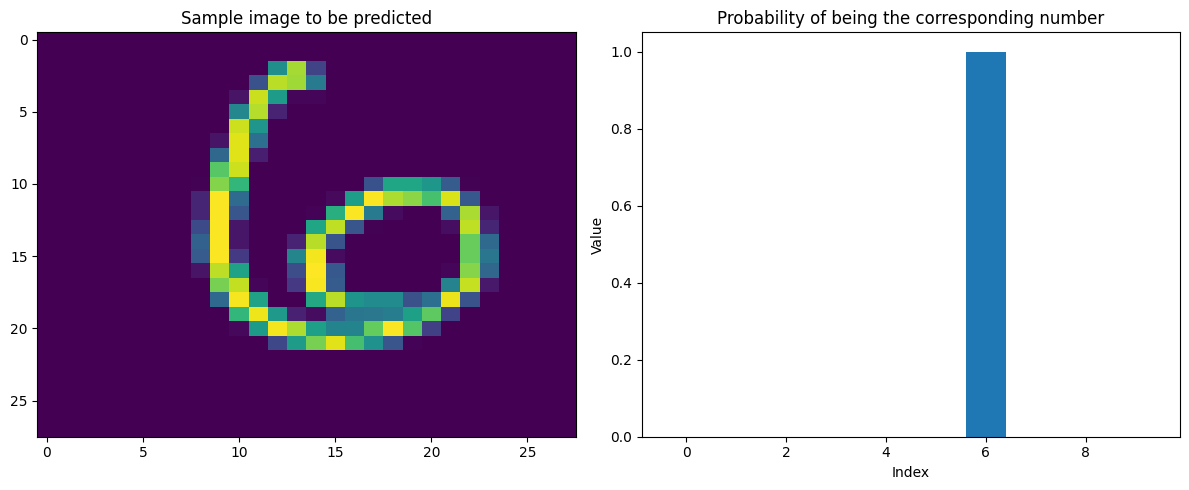

label: 6, predict: 6


In [18]:
service(100)

1/1 [==============================] - 0s 22ms/step


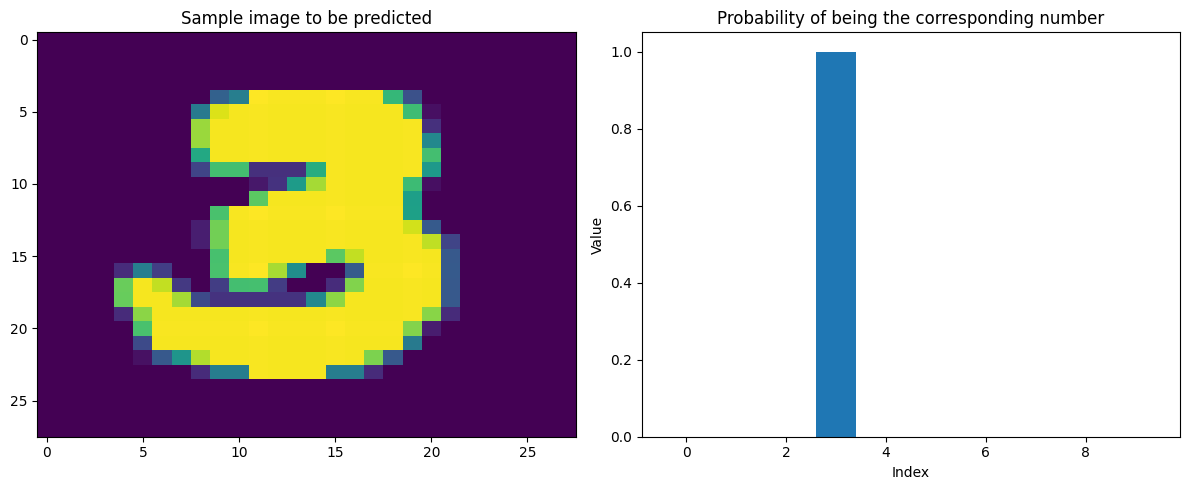

label: 3, predict: 3


In [19]:
service(200)